In [19]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# 데이터 경로 설정
data_path = "./dataset/train/digital_img"  # 여기에는 데이터셋의 경로를 입력하세요.

# 이미지 데이터 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rescale=1./255,  # 이미지 값을 0과 1 사이로 조정
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=.2
)

# 데이터셋 로딩 및 전처리
train_generator = datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),  # ResNet50의 기본 입력 크기에 맞춤
    batch_size=32,
    class_mode='categorical',  # 다중 클래스 분류
    shuffle=True
)

validation_generator = datagen.flow_from_directory(data_path,
    target_size=(224, 224),  # validation 데이터의 크기는 훈련과 동일하게 설정
    subset='validation'
)

# ResNet50 모델 불러오기 (include_top=False로 변경)
base_model = ResNet50(weights='imagenet', include_top=False)

# 새로운 분류 층 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)  # 클래스 수에 맞게 조정

# 새로운 모델 구성
model = Model(inputs=base_model.input, outputs=predictions)

# 미리 학습된 층은 동결 (Fine-tuning을 위한 기본 설정)
for layer in base_model.layers:
    layer.trainable = False
    
# 모델 컴파일
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

base_model.trainable = True
for i in base_model.layers[:143]:
    i.trainable = False
# Fine-tuning 진행
history = model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
)

Found 526 images belonging to 7 classes.
Found 102 images belonging to 7 classes.
Epoch 1/10
17/17 [==============================] - 42s 2s/step - loss: 2.1611 - accuracy: 0.2167 - val_loss: 1.7559 - val_accuracy: 0.4314
Epoch 2/10
17/17 [==============================] - 36s 2s/step - loss: 1.8067 - accuracy: 0.3973 - val_loss: 1.6793 - val_accuracy: 0.3922
Epoch 3/10
17/17 [==============================] - 34s 2s/step - loss: 1.5944 - accuracy: 0.4240 - val_loss: 1.4051 - val_accuracy: 0.5784
Epoch 4/10
17/17 [==============================] - 34s 2s/step - loss: 1.4343 - accuracy: 0.5513 - val_loss: 1.2779 - val_accuracy: 0.6471
Epoch 5/10
17/17 [==============================] - 34s 2s/step - loss: 1.3494 - accuracy: 0.5551 - val_loss: 1.1711 - val_accuracy: 0.7255
Epoch 6/10
17/17 [==============================] - 34s 2s/step - loss: 1.2297 - accuracy: 0.6407 - val_loss: 1.1324 - val_accuracy: 0.6667
Epoch 7/10
17/17 [==============================] - 34s 2s/step - loss: 1.1314

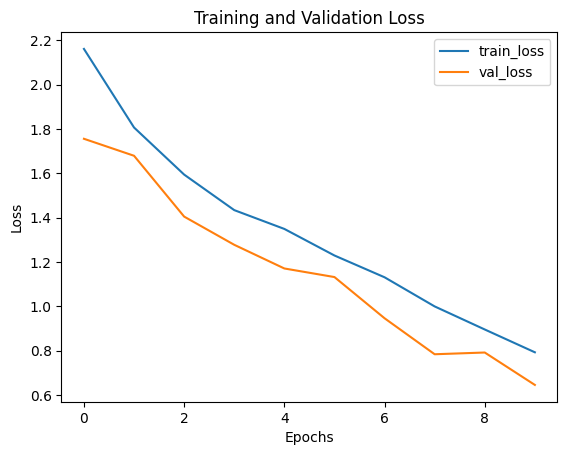

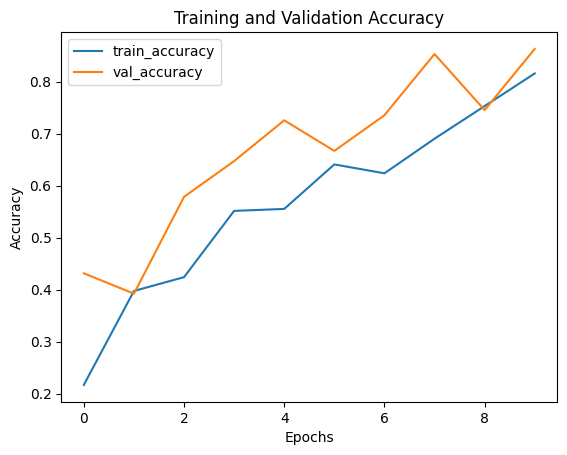

In [20]:
import matplotlib.pyplot as plt

# 손실 그래프
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 정확도 그래프
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [27]:
import numpy as np
from tensorflow.keras.preprocessing import image

# 예측할 이미지 로드 및 전처리
image_path = "pred/pre1.jpg"  # 예측하고자 하는 이미지의 경로를 입력하세요.
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # 이미지를 [0, 1] 범위로 정규화
# 모델에 입력 이미지 전달하여 예측 수행
predictions = model.predict(img_array)

# 예측 결과 출력
predicted_class = np.argmax(predictions)

class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

print(np.max(predictions))
print("Predicted label:", predicted_label)

1/1 [==============================] - 0s 83ms/step
0.5181303
Predicted label: d1_3


In [30]:
model.save("kumoh.h5")

In [31]:
from tensorflow.keras.models import load_model

# 저장된 모델 불러오기
loaded_model = load_model("kumoh.h5")

In [32]:
import numpy as np
from tensorflow.keras.preprocessing import image

# 예측할 이미지 로드 및 전처리
image_path = "pred/pre1.jpg"  # 예측하고자 하는 이미지의 경로를 입력하세요.
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # 이미지를 [0, 1] 범위로 정규화
# 모델에 입력 이미지 전달하여 예측 수행
predictions = loaded_model.predict(img_array)

# 예측 결과 출력
predicted_class = np.argmax(predictions)

class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

print(np.max(predictions))
print("Predicted label:", predicted_label)

1/1 [==============================] - 1s 856ms/step
0.5181303
Predicted label: d1_3
